In [1]:
import os
import ctypes
import glob

# 1. Define the root of your environment (from your logs)
env_root = "/users/7/kanth042/.conda/envs/CV"

# 2. Search for the "good" libnvJitLink library in your conda folder
# It is usually buried inside site-packages/nvidia/...
patterns = [
    f"{env_root}/lib/python3.10/site-packages/nvidia/nvjitlink/lib/libnvJitLink.so.12",
    f"{env_root}/lib/libnvJitLink.so.12"
]

jit_lib_path = None
for p in patterns:
    matches = glob.glob(p)
    if matches:
        jit_lib_path = matches[0]
        break

# 3. Force-load the library if found
if jit_lib_path:
    print(f"Found local library: {jit_lib_path}")
    try:
        # RTLD_GLOBAL ensures other libs (like cusparse) can see the symbols in this one
        ctypes.CDLL(jit_lib_path, mode=ctypes.RTLD_GLOBAL)
        print("FORCE LOAD SUCCESS: The system is now using your local version.")
    except OSError as e:
        print(f"Failed to load: {e}")
else:
    print("CRITICAL: Could not find libnvJitLink.so.12 in your conda env.")

# 4. NOW import torch
import torch
print(f"Torch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

try:
    x = torch.randn(1).cuda()
    print("Tensor allocation: Success")
except Exception as e:
    print(f"Allocation failed: {e}")

Found local library: /users/7/kanth042/.conda/envs/CV/lib/python3.10/site-packages/nvidia/nvjitlink/lib/libnvJitLink.so.12
FORCE LOAD SUCCESS: The system is now using your local version.
Torch Version: 2.5.1+cu124
CUDA Available: True
Tensor allocation: Success


In [2]:
# Cell 1: Imports, config, basic utilities

from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any, List
from pathlib import Path
from collections import OrderedDict
import os, math, json, itertools

import numpy as np
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    from torchvision import transforms
    from transformers import AutoModel
except Exception:
    torch = None; nn = None; transforms = None; AutoModel = None

try:
    import cv2
except Exception:
    cv2 = None

try:
    from PIL import Image
except Exception:
    Image = None

# ---- CONFIG -----------------------------------------------------------------

CKPT_PATH = "checkpoints/dinov3/best_dinov3_classifier_reduced.pth"
MANUAL_CLASS: Optional[int] = None  # Set 0-9 to force class, None to use classifier

DA3_MODEL = "depth-anything/DA3-LARGE"
USE_DA3 = True

RETARGET_DIRECTION = "width"  # "width" or "height"
KEEP_RATIO = 0.50
CUDA_DEVICE = "cuda"

HF_TOKEN = os.environ.get("HUGGING_FACE_HUB_TOKEN", None)

# ---- BASIC ARRAY & IMAGE UTILITIES -----------------------------------------

def to_float01(img: np.ndarray) -> np.ndarray:
    x = img.astype(np.float32)
    if x.max() > 1.5:
        x /= 255.0
    return x

def clamp01(x: np.ndarray) -> np.ndarray:
    return np.clip(x, 0.0, 1.0).astype(np.float32)

def normalize01(x: np.ndarray, eps=1e-6) -> np.ndarray:
    m, M = float(x.min()), float(x.max())
    if M - m < eps:
        return np.zeros_like(x, dtype=np.float32)
    return ((x - m) / (M - m + eps)).astype(np.float32)

def rgb2gray(img: np.ndarray) -> np.ndarray:
    if img.ndim == 2:
        return to_float01(img)
    x = to_float01(img)
    if x.shape[2] == 3:
        r, g, b = x[..., 0], x[..., 1], x[..., 2]
        return (0.299 * r + 0.587 * g + 0.114 * b).astype(np.float32)
    return x[..., 0].astype(np.float32)

def conv2(img: np.ndarray, k: np.ndarray) -> np.ndarray:
    """Slow python conv2, only used if OpenCV is absent."""
    H, W = img.shape
    kh, kw = k.shape
    ph, pw = kh // 2, kw // 2
    pad = np.pad(img, ((ph, ph), (pw, pw)), mode="reflect")
    out = np.zeros_like(img, dtype=np.float32)
    for i in range(H):
        for j in range(W):
            out[i, j] = np.sum(pad[i:i + kh, j:j + kw] * k)
    return out

def sobel_grad(gray: np.ndarray):
    """Return gx, gy, normalized gradient magnitude."""
    if cv2 is not None:
        g = gray.astype(np.float32)
        gx = cv2.Sobel(g, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(g, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(gx * gx + gy * gy).astype(np.float32)
        return gx, gy, normalize01(mag)
    # Fallback
    kx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=np.float32)
    ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=np.float32)
    gx = conv2(gray, kx)
    gy = conv2(gray, ky)
    mag = np.sqrt(gx * gx + gy * gy).astype(np.float32)
    return gx, gy, normalize01(mag)

def sobel_grad_mag(gray: np.ndarray) -> np.ndarray:
    return sobel_grad(gray)[2]

def imread(path: str | Path) -> np.ndarray:
    p = str(path)
    if cv2 is not None:
        bgr = cv2.imread(p, cv2.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(p)
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    if Image is not None:
        return np.array(Image.open(p).convert("RGB"))
    raise ImportError("Need OpenCV or PIL for I/O.")

def imwrite(path: str | Path, img01: np.ndarray):
    arr = (clamp01(img01) * 255).astype(np.uint8)
    p = str(path)
    if cv2 is not None:
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        cv2.imwrite(p, bgr)
        return
    if Image is not None:
        Image.fromarray(arr).save(p)
        return
    raise ImportError("Need OpenCV or PIL for I/O.")

# ---- VISUALIZATION HELPERS --------------------------------------------------

def show_image(img: np.ndarray, title: str = "", cmap: Optional[str] = None, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_images_grid(images, titles=None, cmaps=None, cols=3, figsize=(15, 8)):
    n = len(images)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        ax = plt.subplot(rows, cols, i + 1)
        cmap = None
        if cmaps is not None and i < len(cmaps):
            cmap = cmaps[i]
        if img.ndim == 2:
            ax.imshow(img, cmap=cmap or "gray")
        else:
            ax.imshow(img)
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [3]:
# Cell 2: VST saliency transformer (RGB-VST)

import sys

# Add RGB_VST to path if not already there
rgb_vst_path = "RGB_VST"
if rgb_vst_path not in sys.path:
    sys.path.insert(0, rgb_vst_path)

class SaliencyArgs:
    def __init__(self):
        self.img_size = 224
        self.pretrained_model = "RGB_VST/pretrained_model/80.7_T2T_ViT_t_14.pth.tar"
        self.save_model_dir = "RGB_VST/checkpoint/"

def extract_highest_res_tensor(output, debug=False):
    """Extract the highest resolution tensor from model output."""
    import torch as _torch

    def find_all_tensors(obj, tensors=None):
        if tensors is None:
            tensors = []
        if isinstance(obj, _torch.Tensor):
            tensors.append(obj)
        elif isinstance(obj, (list, tuple)):
            for item in obj:
                find_all_tensors(item, tensors)
        return tensors

    all_tensors = find_all_tensors(output)
    if len(all_tensors) == 0:
        raise ValueError("No tensors found in model output")

    best_tensor = None
    best_size = 0
    for tensor in all_tensors:
        if tensor.ndim >= 2:
            spatial_size = tensor.shape[-2] * tensor.shape[-1]
            if spatial_size > best_size:
                best_size = spatial_size
                best_tensor = tensor

    if debug:
        print(f"[VST DEBUG] Found {len(all_tensors)} tensors")
        print(f"[VST DEBUG] Selected tensor with shape: {best_tensor.shape}")
        print(f"[VST DEBUG] Spatial resolution: {best_tensor.shape[-2]}x{best_tensor.shape[-1]}")

    return best_tensor

def get_saliency_map(model, img: np.ndarray, img_size=224,
                     use_highest_res=True, debug=False, device="cuda") -> np.ndarray:
    """Generate saliency map using RGB-VST model (returns H×W float32 in [0,1])."""
    import torch as _torch

    if isinstance(img, np.ndarray):
        img_pil = Image.fromarray(img)
    else:
        img_pil = img

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    model.eval()
    with _torch.no_grad():
        pred = model(img_tensor)

        if debug:
            print(f"\n[VST DEBUG] Model output type: {type(pred)}")
            if isinstance(pred, (list, tuple)):
                print(f"[VST DEBUG] Output len: {len(pred)}")

        if use_highest_res:
            sal_map = extract_highest_res_tensor(pred, debug=debug)
        else:
            def extract_first(obj):
                if isinstance(obj, _torch.Tensor):
                    return obj
                elif isinstance(obj, (list, tuple)):
                    return extract_first(obj[0])
            sal_map = extract_first(pred)

        sal_map = _torch.sigmoid(sal_map)
        sal_map = sal_map.squeeze().cpu().numpy().astype(np.float32)

    # Resize back to original image size
    H, W = img.shape[:2]
    if cv2 is not None:
        sal_map_resized = cv2.resize(sal_map, (W, H), interpolation=cv2.INTER_LINEAR)
    else:
        from scipy.ndimage import zoom
        scale_h = H / sal_map.shape[-2]
        scale_w = W / sal_map.shape[-1]
        sal_map_resized = zoom(sal_map, (scale_h, scale_w), order=1)

    return normalize01(sal_map_resized)

# ---- Load VST model ---------------------------------------------------------

USE_VST_SALIENCY = False
vst_model = None

try:
    print("Loading RGB-VST saliency model...")

    from Models.ImageDepthNet import ImageDepthNet  # from your RGB_VST repo

    saliency_args = SaliencyArgs()
    vst_model = ImageDepthNet(saliency_args).to(CUDA_DEVICE)

    model_path = os.path.join(saliency_args.save_model_dir, "RGB_VST.pth")
    if not Path(model_path).exists():
        raise FileNotFoundError(f"VST checkpoint not found at {model_path}")

    state_dict = torch.load(model_path, map_location=CUDA_DEVICE)

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] if k.startswith("module.") else k
        new_state_dict[name] = v

    vst_model.load_state_dict(new_state_dict)
    vst_model.eval()

    USE_VST_SALIENCY = True
    print(f"✓ VST model loaded from {model_path}")

except Exception as e:
    print(f"✗ VST model failed: {e}")
    import traceback
    print(traceback.format_exc())


Loading RGB-VST saliency model...


/users/7/kanth042/.conda/envs/CV/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/users/7/kanth042/.conda/envs/CV/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/users/7/kanth042/.conda/envs/CV/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


adopt transformer encoder for tokens-to-token
Model loaded from PruneRepaint/RGB_VST/pretrained_model/80.7_T2T_ViT_t_14.pth.tar
✓ VST model loaded from PruneRepaint/RGB_VST/checkpoint/RGB_VST.pth


/tmp/ipykernel_1193163/1811026361.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=CUDA_DEVICE)


In [4]:
# Cell 3: DINOv3 composition classifier

CLASS_NAMES = [
    "RuleOfThirds", "Centered", "Diagonal", "Horizontal", "Vertical",
    "Triangle", "Curves", "RadialPerspective", "DensePattern", "Scatter"
]

class DINOv3Classifier10(nn.Module):
    def __init__(self, num_classes=10,
                 model_name="facebook/dinov3-vitb16-pretrain-lvd1689m",
                 token: Optional[str] = None):
        super().__init__()
        if AutoModel is None:
            raise ImportError("transformers not installed.")
        extra = {}
        if token:
            extra["token"] = token
        self.backbone = AutoModel.from_pretrained(model_name, **extra)
        self.backbone.eval()
        for p in self.backbone.parameters():
            p.requires_grad = False
        hidden = self.backbone.config.hidden_size
        self.head = nn.Linear(hidden, num_classes)

    def forward(self, x):
        with torch.no_grad():
            out = self.backbone(x)
            feats = out.pooler_output
        return self.head(feats)

class CompClassifier:
    def __init__(self, ckpt_path: str, device: str = "cuda",
                 model_name="facebook/dinov3-vitb16-pretrain-lvd1689m",
                 token: Optional[str] = None):
        if torch is None:
            raise ImportError("PyTorch/Transformers required for classifier.")
        self.device = torch.device(device)
        self.model = DINOv3Classifier10(model_name=model_name, token=token).to(self.device)
        blob = torch.load(ckpt_path, map_location=self.device)
        state = blob.get("model_state_dict", blob)
        self.model.head.load_state_dict(state)
        self.model.eval()
        self.tf = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    @torch.no_grad()
    def predict(self, img_uint8: np.ndarray) -> Tuple[int, np.ndarray]:
        if Image is None:
            raise RuntimeError("Pillow required.")
        pil = Image.fromarray(img_uint8)
        ten = self.tf(pil).unsqueeze(0).to(self.device)
        logits = self.model(ten)
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy().astype(np.float32)
        cls = int(np.argmax(probs))
        return cls, probs

def choose_class(img_uint8: np.ndarray,
                 clf: Optional[CompClassifier],
                 manual: Optional[int]) -> Tuple[int, np.ndarray]:
    if manual is not None:
        probs = np.zeros(10, dtype=np.float32)
        probs[manual] = 1.0
        return manual, probs
    if clf is None:
        probs = np.zeros(10, dtype=np.float32)
        probs[9] = 1.0  # Scatter fallback
        return 9, probs
    return clf.predict(img_uint8)

# Instantiate classifier (if checkpoint exists)
clf = None
if CKPT_PATH and Path(CKPT_PATH).exists() and torch is not None:
    try:
        clf = CompClassifier(CKPT_PATH, device=CUDA_DEVICE, token=HF_TOKEN)
        print("✓ Composition classifier loaded.")
    except Exception as e:
        print("[Classifier] init failed:", e)
        clf = None
else:
    print("Classifier OFF (no checkpoint).")


✓ Composition classifier loaded.


/tmp/ipykernel_1193163/2627395659.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blob = torch.load(ckpt_path, map_location=self.device)


In [5]:
# Cell 4: Depth Anything 3 wrapper (DA3)

class DepthAnything3Wrapper:
    def __init__(self, checkpoint: str = None, device: str = "cuda"):
        self.device = device
        self.ok = False
        self.m = None
        try:
            from depth_anything_3.api import DepthAnything3
            model_id = checkpoint if checkpoint else DA3_MODEL
            self.m = DepthAnything3.from_pretrained(model_id)
            import torch as _torch
            self.m.to(device).eval()
            try:
                _torch.set_float32_matmul_precision("high")
            except Exception:
                pass
            self.ok = True
            print("✓ DA3 depth model loaded.")
        except Exception as e:
            print("[DA3] init failed:", e)
            self.ok = False

    def infer(self, img_uint8: np.ndarray) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
        if not self.ok:
            return None, None
        try:
            import torch as _torch
            with _torch.inference_mode():
                with _torch.autocast(self.device, dtype=_torch.bfloat16):
                    pred = self.m.inference([img_uint8[..., :3]])
            D = np.array(pred.depth[0], dtype=np.float32)
            C = np.array(pred.conf[0], dtype=np.float32)
            return D, C
        except Exception as e:
            print("[DA3] inference error:", e)
            return None, None

da3 = DepthAnything3Wrapper(device=CUDA_DEVICE) if USE_DA3 else None


[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70
[INFO ] using MLP layer as FFN
✓ DA3 depth model loaded.


In [6]:
# Cell 5: Geometry helpers

def dilate_mask(mask01: np.ndarray, rho: int) -> np.ndarray:
    if rho < 1:
        return mask01
    m = (mask01 > 0.5).astype(np.uint8)
    if cv2 is not None:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * rho + 1, 2 * rho + 1))
        d = cv2.dilate(m * 255, kernel)
        return (d > 0).astype(np.float32)
    return m.astype(np.float32)

def dt_high_near(mask01: np.ndarray) -> np.ndarray:
    m = (mask01 > 0.5).astype(np.uint8)
    inv = (m == 0).astype(np.uint8)
    if cv2 is not None:
        dt = cv2.distanceTransform(inv * 255, cv2.DIST_L2, 3).astype(np.float32)
        return normalize01(1.0 - normalize01(dt))
    return normalize01(inv.astype(np.float32))

def canny_edges(gray01: np.ndarray) -> np.ndarray:
    if cv2 is None:
        return (sobel_grad_mag(gray01) > 0.3).astype(np.float32)
    lo = int(0.1 * 255)
    hi = int(0.3 * 255)
    e = cv2.Canny((gray01 * 255).astype(np.uint8), lo, hi)
    return (e > 0).astype(np.float32)

def rho_pixels(H: int, W: int, frac: float) -> int:
    return max(1, int(round(frac * min(H, W))))

def create_ball(center: Tuple[float, float], radius: float, shape: Tuple[int, int]) -> np.ndarray:
    H, W = shape
    yy, xx = np.mgrid[0:H, 0:W]
    cx, cy = center
    return (((xx - cx)**2 + (yy - cy)**2) <= radius**2).astype(np.float32)

def euclidean(p1, p2):
    return float(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def adaptive_hough_lines(gray: np.ndarray, angle_range: Tuple[float, float],
                         min_length_frac: float = 0.2) -> List[Dict]:
    """Adaptive Hough line detection with angle filtering."""
    if cv2 is None:
        return []
    H, W = gray.shape
    v = np.median(gray)
    sigma = 0.33
    lo = int(max(0, (1.0 - sigma) * v * 255))
    hi = int(min(255, (1.0 + sigma) * v * 255))
    edges = cv2.Canny((gray * 255).astype(np.uint8), lo, hi)

    edge_density = edges.sum() / (H * W * 255)
    threshold = int(80 + 40 * edge_density)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180,
                            threshold=threshold,
                            minLineLength=int(min_length_frac * min(H, W)),
                            maxLineGap=int(0.02 * min(H, W)))
    if lines is None:
        return []

    a0, a1 = angle_range
    results = []
    for l in lines:
        x1, y1, x2, y2 = l[0]
        ang = (math.degrees(math.atan2(y2 - y1, x2 - x1)) + 180) % 180
        if a0 <= a1:
            in_range = (a0 <= ang <= a1)
        else:
            in_range = (ang >= a0 or ang <= a1)
        if not in_range:
            continue
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        results.append({
            "coords": (x1, y1, x2, y2),
            "angle": ang,
            "length": length,
            "confidence": min(1.0, length / (0.5 * (H + W)))
        })
    return results

def render_lines_to_mask(lines: List[Dict], shape: Tuple[int, int], thickness: int = 3) -> np.ndarray:
    H, W = shape
    mask = np.zeros((H, W), dtype=np.uint8)
    if cv2 is None:
        return mask.astype(np.float32)
    for line in lines:
        x1, y1, x2, y2 = line["coords"]
        cv2.line(mask, (x1, y1), (x2, y2), 255, thickness)
    return (mask > 0).astype(np.float32)


In [7]:
# Cell 6: Energy recipes using VST saliency

@dataclass
class EnergyWeights:
    w1_grad: float = 0.4   # |∇I|
    w2_depth: float = 0.6  # |∇D|
    w3_class: float = 1.0  # class term

def energy_recipe_class_0(img01, sal, depth):
    """
    Class 0: Rule of Thirds
    Strategy: emphasize rule-of-thirds power points modulated by VST saliency.
    """
    H, W = img01.shape[:2]
    dbg = {}
    power_points = [(W / 3, H / 3), (2 * W / 3, H / 3),
                    (W / 3, 2 * H / 3), (2 * W / 3, 2 * H / 3)]
    anchors = np.zeros((H, W), dtype=np.float32)
    for px, py in power_points:
        anchors = np.maximum(anchors, create_ball((px, py), 0.06 * min(H, W), (H, W)))
    T = dt_high_near(anchors) * normalize01(sal)
    dbg["anchors"] = anchors
    return normalize01(T), dbg

def energy_recipe_class_1(img01, sal, depth):
    """
    Class 1: Centered
    Strategy: emphasize central region modulated by VST saliency.
    """
    H, W = img01.shape[:2]
    dbg = {}
    center = (W / 2, H / 2)
    center_ball = create_ball(center, 0.10 * min(H, W), (H, W))
    T = dt_high_near(center_ball) * normalize01(sal)
    dbg["center_ball"] = center_ball
    return normalize01(T), dbg

def energy_recipe_class_2(img01, sal, depth):
    """
    Class 2: Diagonal
    Protect diagonal lines, weighted by VST saliency.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    lines1 = adaptive_hough_lines(gray, (35, 55), min_length_frac=0.2)
    lines2 = adaptive_hough_lines(gray, (125, 145), min_length_frac=0.2)
    diag_lines = lines1 + lines2

    if diag_lines:
        mask = render_lines_to_mask(diag_lines, (H, W), thickness=3)
        mask = dilate_mask(mask, rho_pixels(H, W, 0.03))
        grad_mag = sobel_grad_mag(gray)
        line_importance = mask * grad_mag * normalize01(sal)
        T = dt_high_near(mask) * (0.5 + 0.5 * normalize01(line_importance))
        dbg["diag_lines"] = mask
        dbg["line_importance"] = line_importance
        return normalize01(T), dbg

    return normalize01(sal), dbg

def energy_recipe_class_3(img01, sal, depth):
    """
    Class 3: Horizontal (horizon)
    Detect long horizontal lines; optionally validate with depth.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    horiz_lines = adaptive_hough_lines(gray, (170, 10), min_length_frac=0.3)
    horiz_lines = [l for l in horiz_lines if l["length"] > 0.3 * W]

    if depth is not None and horiz_lines:
        Dn = normalize01(depth)
        validated = []
        for l in horiz_lines:
            x1, y1, x2, y2 = l["coords"]
            y = int((y1 + y2) / 2)
            above = Dn[max(0, y - 20):y, :].mean() if y > 20 else 0
            below = Dn[y:min(H, y + 20), :].mean() if y < H - 20 else 0
            if above > below * 1.5:
                validated.append(l)
        if validated:
            horiz_lines = validated

    if horiz_lines:
        mask = render_lines_to_mask(horiz_lines, (H, W), thickness=5)
        if cv2 is not None:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (W // 10, 5))
            mask = cv2.dilate((mask * 255).astype(np.uint8), kernel) / 255.0
        if depth is not None:
            depth_grad_y = sobel_grad_mag(normalize01(depth))
            mask = normalize01(mask + 0.3 * depth_grad_y)
        T = dt_high_near(mask)
        dbg["horizon"] = mask
        return normalize01(T), dbg

    return normalize01(sal), dbg

def energy_recipe_class_4(img01, sal, depth):
    """
    Class 4: Vertical lines
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    vert_lines = adaptive_hough_lines(gray, (80, 100), min_length_frac=0.15)
    if vert_lines:
        mask = render_lines_to_mask(vert_lines, (H, W), thickness=3)
        mask = dilate_mask(mask, rho_pixels(H, W, 0.03))
        importance = mask * normalize01(sal)
        if depth is not None:
            depth_grad_x = sobel_grad(normalize01(depth))[0]
            importance += 0.3 * mask * normalize01(np.abs(depth_grad_x))
        T = dt_high_near(mask) * (0.5 + 0.5 * normalize01(importance))
        dbg["vert_lines"] = mask
        return normalize01(T), dbg

    return normalize01(sal), dbg

def energy_recipe_class_5(img01, sal, depth):
    """
    Class 5: Triangle
    Simplified: pick 3 strongest saliency peaks, create anchors.
    """
    H, W = img01.shape[:2]
    dbg = {}
    sal_flat = sal.reshape(-1)
    idx_sorted = np.argsort(-sal_flat)  # descending
    peaks = []
    used = np.zeros_like(sal_flat, dtype=bool)
    radius = int(0.05 * min(H, W))

    for idx in idx_sorted:
        if len(peaks) >= 3:
            break
        if used[idx]:
            continue
        y, x = divmod(idx, W)
        peaks.append((x, y))
        yy, xx = np.ogrid[:H, :W]
        mask = ((xx - x)**2 + (yy - y)**2) <= radius**2
        used[mask.reshape(-1)] = True

    if len(peaks) < 3:
        return normalize01(sal), dbg

    vertex_balls = np.zeros((H, W), dtype=np.float32)
    for x, y in peaks:
        vertex_balls = np.maximum(vertex_balls,
                                  create_ball((x, y), 0.06 * min(H, W), (H, W)))
    T = dt_high_near(vertex_balls) * normalize01(sal)
    dbg["triangle_balls"] = vertex_balls
    return normalize01(T), dbg

def energy_recipe_class_6(img01, sal, depth):
    """
    Class 6: Curves
    Structure tensor coherence + edges + saliency.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    import scipy.ndimage as ndi
    gx, gy, _ = sobel_grad(gray)
    Jxx = ndi.gaussian_filter(gx * gx, sigma=2)
    Jyy = ndi.gaussian_filter(gy * gy, sigma=2)
    Jxy = ndi.gaussian_filter(gx * gy, sigma=2)

    coherence = np.sqrt((Jxx - Jyy)**2 + 4 * Jxy * Jxy) / (Jxx + Jyy + 1e-6)
    coherence = normalize01(coherence)

    edges = canny_edges(gray)
    if cv2 is not None:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        skeleton = cv2.morphologyEx((edges * 255).astype(np.uint8),
                                    cv2.MORPH_CLOSE, kernel) / 255.0
    else:
        skeleton = edges

    skeleton = dilate_mask(skeleton, rho_pixels(H, W, 0.02))
    T = 0.5 * dt_high_near(skeleton) + 0.3 * coherence + 0.2 * normalize01(sal)
    dbg["skeleton"] = skeleton
    dbg["coherence"] = coherence
    return normalize01(T), dbg

def line_passes_through_point(line: Dict, point: Tuple[float, float], tolerance: float) -> bool:
    x1, y1, x2, y2 = line["coords"]
    px, py = point
    num = abs((y2 - y1) * px - (x2 - x1) * py + x2 * y1 - y2 * x1)
    denom = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    if denom < 1e-6:
        return False
    return (num / denom) < tolerance

def estimate_vanishing_point_ransac(lines: List[Dict], shape: Tuple[int, int],
                                    n_iterations: int = 100) -> Optional[Tuple[int, int]]:
    if len(lines) < 10:
        return None
    H, W = shape
    best_vp = None
    best_inliers = 0
    import random

    for _ in range(n_iterations):
        l1, l2 = random.sample(lines, 2)
        x1, y1, x2, y2 = l1["coords"]
        x3, y3, x4, y4 = l2["coords"]

        denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if abs(denom) < 1e-6:
            continue

        px = ((x1 * y2 - y1 * x2) * (x3 - x4) -
              (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
        py = ((x1 * y2 - y1 * x2) * (y3 - y4) -
              (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

        if not (-0.5 * W <= px <= 1.5 * W and -0.5 * H <= py <= 1.5 * H):
            continue

        vp_candidate = (px, py)
        inliers = 0
        for line in lines:
            if line_passes_through_point(line, vp_candidate, tolerance=5):
                inliers += 1
        if inliers > best_inliers:
            best_inliers = inliers
            best_vp = vp_candidate

    if best_vp is None:
        return None
    return int(best_vp[0]), int(best_vp[1])

def energy_recipe_class_7(img01, sal, depth):
    """
    Class 7: RadialPerspective
    Estimate vanishing point from lines, create radial structure.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}
    all_lines = adaptive_hough_lines(gray, (0, 180), min_length_frac=0.2)
    strong_lines = [l for l in all_lines if l["confidence"] > 0.6]
    vp = estimate_vanishing_point_ransac(strong_lines, (H, W))
    if vp is None:
        vp = (W // 2, H // 2)

    ray_mask = np.zeros((H, W), dtype=np.uint8)
    if cv2 is not None:
        for i in range(36):
            angle = 2 * np.pi * i / 36
            x2 = int(vp[0] + 2 * W * np.cos(angle))
            y2 = int(vp[1] + 2 * H * np.sin(angle))
            cv2.line(ray_mask, tuple(map(int, vp)), (x2, y2), 255, 1)
    ray_mask = (ray_mask > 0).astype(np.float32)
    ray_mask = dilate_mask(ray_mask, rho_pixels(H, W, 0.02))
    vp_ball = create_ball(vp, 0.06 * min(H, W), (H, W))
    T = 0.6 * dt_high_near(ray_mask) + 0.4 * dt_high_near(vp_ball)
    if depth is not None:
        yy, xx = np.mgrid[0:H, 0:W]
        dist_from_vp = np.sqrt((xx - vp[0])**2 + (yy - vp[1])**2)
        expected_depth = normalize01(dist_from_vp)
        actual_depth = normalize01(depth)
        consistency = 1 - np.abs(expected_depth - actual_depth)
        T *= (0.7 + 0.3 * consistency)
    dbg["rays"] = ray_mask
    dbg["vp_ball"] = vp_ball
    return normalize01(T), dbg

def energy_recipe_class_8(img01, sal, depth):
    """
    Class 8: DensePattern
    Same FFT-based periodic grid, but keep saliency anomalies.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    import numpy.fft as fft
    proj_x = gray.mean(axis=0) - gray.mean()
    proj_y = gray.mean(axis=1) - gray.mean()
    fx = np.abs(fft.rfft(proj_x))
    fy = np.abs(fft.rfft(proj_y))

    def find_top_period(f):
        f_search = f[2:len(f) // 2]
        if len(f_search) == 0:
            return 0
        idx = np.argmax(f_search) + 2
        if f[idx] > 0.3 * f[1:].max():
            return idx
        return 0

    kx = find_top_period(fx)
    ky = find_top_period(fy)

    cell_mask = np.zeros((H, W), dtype=np.uint8)
    if cv2 is not None:
        if kx > 0:
            px = max(4, int(W / (2 * kx)))
            for x in range(0, W, px):
                cv2.line(cell_mask, (x, 0), (x, H - 1), 255, 1)
        if ky > 0:
            py = max(4, int(H / (2 * ky)))
            for y in range(0, H, py):
                cv2.line(cell_mask, (0, y), (W - 1, y), 255, 1)
    cell_boundary = (cell_mask > 0).astype(np.float32)

    T = normalize01(1.0 - cell_boundary)
    import scipy.ndimage as ndi
    sal_var = ndi.generic_filter(sal, np.std, size=max(5, min(H, W) // 10))
    T *= (0.7 + 0.3 * normalize01(sal_var))
    dbg["cell_boundary"] = cell_boundary
    return normalize01(T), dbg

def energy_recipe_class_9(img01, sal, depth):
    """
    Class 9: Scatter
    Strategy: mostly VST saliency, plus edges.
    """
    H, W = img01.shape[:2]
    gray = rgb2gray(img01)
    dbg = {}

    edges = canny_edges(gray)
    T = 0.7 * normalize01(sal) + 0.3 * normalize01(edges)
    dbg["edges"] = edges
    return normalize01(T), dbg

def build_energy(img_f01: np.ndarray, klass: int,
                 depth: Optional[np.ndarray],
                 conf: Optional[np.ndarray],
                 vst_sal: Optional[np.ndarray],
                 ew: EnergyWeights) -> Tuple[np.ndarray, Dict]:
    """
    Build complete energy map:
        E = w1 * |∇I| + w2 * |∇D| * conf + w3 * T_class(VST, geometry, depth)
    """
    gray = rgb2gray(img_f01)
    H, W = gray.shape

    # Base gradient energy
    G = sobel_grad_mag(gray)

    # Depth edge energy
    if depth is not None:
        if depth.shape != (H, W):
            if cv2 is not None:
                depth = cv2.resize(depth.astype(np.float32), (W, H),
                                   interpolation=cv2.INTER_LINEAR)
                if conf is not None:
                    conf = cv2.resize(conf.astype(np.float32), (W, H),
                                      interpolation=cv2.INTER_LINEAR)
            else:
                from scipy.ndimage import zoom
                scale_h = H / depth.shape[0]
                scale_w = W / depth.shape[1]
                depth = zoom(depth.astype(np.float32), (scale_h, scale_w), order=1)
                if conf is not None:
                    conf = zoom(conf.astype(np.float32), (scale_h, scale_w), order=1)
        Dn = normalize01(depth.astype(np.float32))
        dG = sobel_grad_mag(Dn)
        if conf is not None:
            Cn = normalize01(conf.astype(np.float32))
            dE = normalize01(dG * Cn)
        else:
            dE = normalize01(dG)
    else:
        dE = np.zeros_like(G, dtype=np.float32)

    # VST saliency
    if vst_sal is None:
        sal = np.ones_like(G, dtype=np.float32)
    else:
        if vst_sal.shape != (H, W):
            if cv2 is not None:
                sal = cv2.resize(vst_sal.astype(np.float32), (W, H),
                                 interpolation=cv2.INTER_LINEAR)
            else:
                from scipy.ndimage import zoom
                scale_h = H / vst_sal.shape[0]
                scale_w = W / vst_sal.shape[1]
                sal = zoom(vst_sal.astype(np.float32), (scale_h, scale_w), order=1)
        else:
            sal = vst_sal.astype(np.float32)
    sal = normalize01(sal)

    # Class-specific energy
    recipes = [
        energy_recipe_class_0,
        energy_recipe_class_1,
        energy_recipe_class_2,
        energy_recipe_class_3,
        energy_recipe_class_4,
        energy_recipe_class_5,
        energy_recipe_class_6,
        energy_recipe_class_7,
        energy_recipe_class_8,
        energy_recipe_class_9,
    ]
    T, dbg = recipes[klass](img_f01, sal, depth)

    # Combine
    E = ew.w1_grad * G + ew.w2_depth * dE + ew.w3_class * T
    E = normalize01(E)

    dbg["G"] = G
    dbg["dE"] = dE
    dbg["T"] = T
    dbg["vst_saliency"] = sal
    dbg["E"] = E

    return E, dbg


In [8]:
# Cell 7: Seam carving (Numba) + multi-operator planning

try:
    from numba import njit
except Exception:
    def njit(*args, **kwargs):
        def wrap(f): return f
        return wrap

@njit
def find_vertical_seam_fast(energy: np.ndarray) -> np.ndarray:
    H, W = energy.shape
    M = np.zeros((H, W), dtype=np.float32)
    M[0, :] = energy[0, :]
    for i in range(1, H):
        for j in range(W):
            if j == 0:
                M[i, j] = energy[i, j] + min(M[i - 1, j], M[i - 1, j + 1])
            elif j == W - 1:
                M[i, j] = energy[i, j] + min(M[i - 1, j - 1], M[i - 1, j])
            else:
                M[i, j] = energy[i, j] + min(M[i - 1, j - 1], M[i - 1, j], M[i - 1, j + 1])

    seam = np.zeros(H, dtype=np.int32)
    seam[H - 1] = np.argmin(M[H - 1, :])
    for i in range(H - 2, -1, -1):
        j = seam[i + 1]
        if j == 0:
            if M[i, j] <= M[i, j + 1]:
                seam[i] = j
            else:
                seam[i] = j + 1
        elif j == W - 1:
            if M[i, j - 1] <= M[i, j]:
                seam[i] = j - 1
            else:
                seam[i] = j
        else:
            if M[i, j - 1] <= M[i, j] and M[i, j - 1] <= M[i, j + 1]:
                seam[i] = j - 1
            elif M[i, j] <= M[i, j + 1]:
                seam[i] = j
            else:
                seam[i] = j + 1
    return seam

@njit
def remove_seam_2d(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    H, W = img.shape
    out = np.zeros((H, W - 1), dtype=img.dtype)
    for i in range(H):
        j = seam[i]
        for k in range(j):
            out[i, k] = img[i, k]
        for k in range(j + 1, W):
            out[i, k - 1] = img[i, k]
    return out

@njit
def remove_seam_3d(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    H, W, C = img.shape
    out = np.zeros((H, W - 1, C), dtype=img.dtype)
    for i in range(H):
        j = seam[i]
        for k in range(j):
            for c in range(C):
                out[i, k, c] = img[i, k, c]
        for k in range(j + 1, W):
            for c in range(C):
                out[i, k - 1, c] = img[i, k, c]
    return out

def remove_vertical_seam(img: np.ndarray, seam: np.ndarray) -> np.ndarray:
    if img.ndim == 3:
        return remove_seam_3d(img, seam)
    return remove_seam_2d(img, seam)

def transpose_image(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3:
        return np.transpose(img, (1, 0, 2))
    return img.T

@dataclass
class MultiOpConfig:
    w_forward: float = 1.0
    seam_energy_q: float = 85.0
    ddvr_tau: float = 0.25
    ddvr_max: float = 0.15
    seams_per_step: int = 1
    scl_factor: float = 0.98
    crop_px_step: int = 4
    max_crop_frac: float = 0.12

    crop_search_steps: int = 6
    scale_search_steps: int = 6
    min_scale: float = 0.7
    max_seam_frac_after_ops: float = 0.35

    w_cost_crop: float = 1.0
    w_cost_scale: float = 0.5
    w_cost_seam: float = 1.0

def check_ddvr(seam: np.ndarray, depth_grad: Optional[np.ndarray],
               tau: float, max_frac: float) -> bool:
    if depth_grad is None:
        return False
    H = len(seam)
    violations = 0
    for i in range(H):
        j = seam[i]
        if depth_grad[i, j] > tau:
            violations += 1
    return (violations / H) > max_frac

def retarget_seam_carving(img: np.ndarray, target_size: Tuple[int, int],
                          energy: np.ndarray, depth: Optional[np.ndarray],
                          cfg: MultiOpConfig, is_vertical: bool) -> Tuple[np.ndarray, List[str]]:
    import time
    current = img.copy()
    current_energy = energy.copy()
    current_depth = depth.copy() if depth is not None else None
    ops_log: List[str] = []

    H, W = current.shape[:2]
    target_h, target_w = target_size

    if is_vertical:
        n_seams = W - target_w
    else:
        current = transpose_image(current)
        current_energy = current_energy.T
        if current_depth is not None:
            current_depth = current_depth.T
        H, W = current.shape[:2]
        n_seams = H - target_h

    depth_grad = None
    if current_depth is not None:
        depth_grad = sobel_grad_mag(normalize01(current_depth))

    print(f"[Seam Carving] Removing {n_seams} seams...")
    start_time = time.time()

    for idx in range(n_seams):
        seam = find_vertical_seam_fast(current_energy)
        if depth_grad is not None and check_ddvr(seam, depth_grad, cfg.ddvr_tau, cfg.ddvr_max):
            ops_log.append("seam_rejected_ddvr")
            print(f"[Seam Carving] DDVR rejection at seam {idx + 1}/{n_seams}")
            break

        current = remove_vertical_seam(current, seam)
        current_energy = remove_seam_2d(current_energy, seam)
        if current_depth is not None:
            current_depth = remove_seam_2d(current_depth, seam)
        if depth_grad is not None:
            depth_grad = remove_seam_2d(depth_grad, seam)

        ops_log.append("seam")
        if (idx + 1) % 50 == 0 or idx == n_seams - 1:
            elapsed = time.time() - start_time
            rate = (idx + 1) / elapsed
            remain = (n_seams - idx - 1) / rate if rate > 0 else 0
            print(f"[Seam Carving] {idx + 1}/{n_seams} seams ({rate:.1f} seams/s, ~{remain:.1f}s remaining)")

    total_time = time.time() - start_time
    print(f"[Seam Carving] Completed {len([o for o in ops_log if o == 'seam'])} seams in {total_time:.2f}s")

    if not is_vertical:
        current = transpose_image(current)
    return current, ops_log

def plan_multiop_width(W: int, target_w: int, energy: np.ndarray,
                       cfg: MultiOpConfig) -> Dict[str, Any]:
    H = energy.shape[0]
    col_importance = energy.mean(axis=0)
    global_energy = float(col_importance.mean())

    max_crop_px = int(cfg.max_crop_frac * W)
    if cfg.crop_search_steps > 1:
        crop_candidates = np.linspace(0, max_crop_px, cfg.crop_search_steps, dtype=np.int32)
    else:
        crop_candidates = np.arange(0, max_crop_px + 1, cfg.crop_px_step, dtype=np.int32)

    if cfg.scale_search_steps > 1:
        scale_candidates = np.linspace(cfg.min_scale, 1.0, cfg.scale_search_steps, dtype=np.float32)
    else:
        scale_candidates = np.array([1.0], dtype=np.float32)

    best = dict(crop_px=0, scale=1.0, seams=max(0, W - target_w))
    best_cost = 1e30

    for crop_px in crop_candidates:
        Wc = W - 2 * int(crop_px)
        if Wc <= target_w:
            continue

        crop_energy = 0.0
        if crop_px > 0:
            crop_energy = float(col_importance[:crop_px].sum() +
                                col_importance[W - crop_px:].sum())

        for s in scale_candidates:
            Ws = int(round(Wc * float(s)))
            if Ws < target_w:
                continue
            seams_needed = Ws - target_w
            seam_frac = seams_needed / float(W)
            if seam_frac > cfg.max_seam_frac_after_ops:
                continue

            scale_penalty = (1.0 - float(s)) * global_energy * Wc
            seam_penalty = seams_needed * global_energy

            cost = (cfg.w_cost_crop * crop_energy +
                    cfg.w_cost_scale * scale_penalty +
                    cfg.w_cost_seam * seam_penalty)

            if cost < best_cost:
                best_cost = cost
                best = dict(crop_px=int(crop_px),
                            scale=float(s),
                            seams=int(seams_needed))

    if best_cost == 1e30:
        best = dict(crop_px=0, scale=1.0, seams=max(0, W - target_w))
    return best

def multiop_retarget_width(img: np.ndarray,
                           target_w: int,
                           energy: np.ndarray,
                           depth: Optional[np.ndarray],
                           cfg: MultiOpConfig) -> Tuple[np.ndarray, List[str]]:
    import time
    H, W = img.shape[:2]
    plan = plan_multiop_width(W, target_w, energy, cfg)
    crop_px = plan["crop_px"]
    scale = plan["scale"]

    current_img = img.copy()
    current_energy = energy.copy()
    current_depth = depth.copy() if depth is not None else None
    ops_log: List[str] = []

    # 1) crop
    if crop_px > 0:
        left = crop_px
        right = W - crop_px
        current_img = current_img[:, left:right, :]
        current_energy = current_energy[:, left:right]
        if current_depth is not None:
            current_depth = current_depth[:, left:right]
        ops_log.append(f"crop:{crop_px}px_per_side")
        H, W = current_img.shape[:2]

    # 2) scale
    if abs(scale - 1.0) > 1e-3:
        new_w = int(round(W * scale))
        if new_w <= target_w:
            new_w = max(target_w, 1)
        if cv2 is not None:
            current_img = cv2.resize(current_img, (new_w, H), interpolation=cv2.INTER_AREA)
            current_energy = cv2.resize(current_energy, (new_w, H),
                                        interpolation=cv2.INTER_LINEAR).astype(np.float32)
            if current_depth is not None:
                current_depth = cv2.resize(current_depth, (new_w, H),
                                           interpolation=cv2.INTER_LINEAR).astype(np.float32)
        else:
            from scipy.ndimage import zoom
            scale_w = new_w / float(W)
            current_img = zoom(current_img, (1.0, scale_w, 1.0), order=1)
            current_energy = zoom(current_energy, (1.0, scale_w), order=1).astype(np.float32)
            if current_depth is not None:
                current_depth = zoom(current_depth, (1.0, scale_w), order=1).astype(np.float32)
        ops_log.append(f"scale:{scale:.3f}->{new_w}px")
        H, W = current_img.shape[:2]

    # 3) seam carving for remaining
    if W > target_w:
        start = time.time()
        current_img, seam_ops = retarget_seam_carving(
            current_img, (H, target_w), current_energy, current_depth, cfg,
            is_vertical=True
        )
        ops_log.extend(seam_ops)
        print(f"[MultiOp] Seam carving stage: {time.time() - start:.2f}s")
    elif W < target_w:
        if cv2 is not None:
            current_img = cv2.resize(current_img, (target_w, H), interpolation=cv2.INTER_AREA)
        else:
            from scipy.ndimage import zoom
            scale_w = target_w / float(W)
            current_img = zoom(current_img, (1.0, scale_w, 1.0), order=1)
        ops_log.append(f"scale_fix:{W}->{target_w}px")

    return current_img, ops_log

def retarget(img_uint8: np.ndarray,
             target_size: Tuple[int, int],
             klass: int,
             energy: np.ndarray,
             depth: Optional[np.ndarray],
             conf: Optional[np.ndarray],
             cfg: MultiOpConfig) -> Tuple[np.ndarray, Dict]:
    img01 = to_float01(img_uint8)
    H, W = img01.shape[:2]
    target_w, target_h = target_size

    if depth is not None and depth.shape != (H, W):
        if cv2 is not None:
            depth = cv2.resize(depth.astype(np.float32), (W, H),
                               interpolation=cv2.INTER_LINEAR)
        else:
            from scipy.ndimage import zoom
            scale_h = H / depth.shape[0]
            scale_w = W / depth.shape[1]
            depth = zoom(depth.astype(np.float32), (scale_h, scale_w), order=1)

    ops_log: List[str] = []

    if target_h == H and target_w < W:
        result_img, ops = multiop_retarget_width(img_uint8, target_w, energy, depth, cfg)
        ops_log.extend(ops)
    elif target_w == W and target_h < H:
        img_t = transpose_image(img_uint8)
        E_t = energy.T
        D_t = depth.T if depth is not None else None
        result_t, ops = multiop_retarget_width(img_t, target_h, E_t, D_t, cfg)
        result_img = transpose_image(result_t)
        ops_log.extend([f"h_{op}" for op in ops])
    else:
        is_vertical = (target_w < W)
        result_img, ops = retarget_seam_carving(
            img_uint8, (target_h, target_w), energy, depth, cfg, is_vertical=is_vertical
        )
        ops_log.extend(ops)

    return to_float01(result_img), {"ops": ops_log}


In [9]:
# Cell 8: Pipeline assembly

@dataclass
class PipelineConfig:
    ckpt_path: Optional[str]
    hf_token: Optional[str]
    use_da3: bool
    device: str
    ew: EnergyWeights
    mcfg: MultiOpConfig

class RetargetPipeline:
    def __init__(self, cfg: PipelineConfig,
                 manual_class: Optional[int] = None,
                 comp_clf: Optional[CompClassifier] = None,
                 depth_wrapper: Optional[DepthAnything3Wrapper] = None,
                 vst_model_ref=None):
        self.cfg = cfg
        self.manual_class = manual_class
        self.clf = comp_clf
        self.da3 = depth_wrapper
        self.vst_model = vst_model_ref

        # Warm up numba JIT
        print("[Pipeline] Warming up Numba JIT...", end="", flush=True)
        dummy_energy = np.random.rand(50, 50).astype(np.float32)
        dummy_seam = find_vertical_seam_fast(dummy_energy)
        dummy_img = (np.random.rand(50, 50, 3) * 255).astype(np.uint8)
        _ = remove_vertical_seam(dummy_img, dummy_seam)
        print(" done")

    def run(self, img_uint8: np.ndarray,
            target_wh: Tuple[int, int]) -> Dict[str, Any]:
        import time
        total_start = time.time()

        # 1) Classification
        t0 = time.time()
        klass, probs = choose_class(img_uint8, self.clf, self.manual_class)
        print(f"[Pipeline] Classification: {time.time() - t0:.2f}s -> {CLASS_NAMES[klass]}")

        # 2) Depth
        depth = conf = None
        if self.da3 is not None and self.da3.ok:
            t0 = time.time()
            depth, conf = self.da3.infer(img_uint8)
            print(f"[Pipeline] Depth (DA3): {time.time() - t0:.2f}s")

        # 3) VST saliency
        vst_sal = None
        if USE_VST_SALIENCY and self.vst_model is not None:
            t0 = time.time()
            vst_sal = get_saliency_map(self.vst_model, img_uint8,
                                       img_size=224,
                                       use_highest_res=True,
                                       debug=False,
                                       device=self.cfg.device)
            print(f"[Pipeline] VST saliency: {time.time() - t0:.2f}s")

        # 4) Build energy
        t0 = time.time()
        img01 = to_float01(img_uint8)
        E, dbg = build_energy(img01, klass, depth, conf, vst_sal, self.cfg.ew)
        print(f"[Pipeline] Energy computation: {time.time() - t0:.2f}s")

        # 5) Retarget
        t0 = time.time()
        out, log = retarget(
            img_uint8,
            (int(target_wh[0]), int(target_wh[1])),
            klass,
            energy=E,
            depth=depth,
            conf=conf,
            cfg=self.cfg.mcfg
        )
        print(f"[Pipeline] Retarget (multi-op + seams): {time.time() - t0:.2f}s")

        total_time = time.time() - total_start
        print(f"[Pipeline] TOTAL TIME: {total_time:.2f}s")

        return {
            "out": out,
            "pred_class": int(klass),
            "pred_class_name": CLASS_NAMES[klass],
            "probs": probs.tolist(),
            "log": log,
            "energy_dbg": dbg,
            "depth": depth,
            "depth_conf": conf,
            "vst_saliency": vst_sal,
        }

# Instantiate pipeline

ew = EnergyWeights(w1_grad=0.4, w2_depth=0.6 if USE_DA3 else 0.2, w3_class=1.0)
mcfg = MultiOpConfig()

pipe_cfg = PipelineConfig(
    ckpt_path=CKPT_PATH if (CKPT_PATH and Path(CKPT_PATH).exists()) else None,
    hf_token=HF_TOKEN,
    use_da3=USE_DA3,
    device=CUDA_DEVICE,
    ew=ew,
    mcfg=mcfg
)

pipe = RetargetPipeline(
    pipe_cfg,
    manual_class=MANUAL_CLASS,
    comp_clf=clf,
    depth_wrapper=da3,
    vst_model_ref=vst_model
)

print("Pipeline ready.",
      "Classifier:", "OK" if clf is not None else "OFF",
      "| DA3:", bool(da3 and da3.ok),
      "| VST:", bool(vst_model is not None and USE_VST_SALIENCY))


[Pipeline] Warming up Numba JIT... done
Pipeline ready. Classifier: OK | DA3: True | VST: True


Image size: 461 x 615


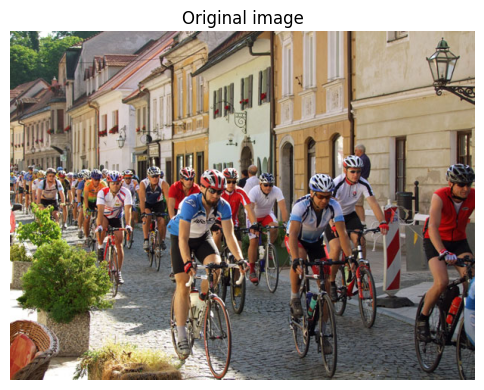

Target size: 461 x 308
[Pipeline] Classification: 0.02s -> RadialPerspective
[INFO ] Processed Images Done taking 0.01237344741821289 seconds. Shape:  torch.Size([1, 3, 378, 504])
[INFO ] Model Forward Pass Done. Time: 0.05113792419433594 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0002503395080566406 seconds
[Pipeline] Depth (DA3): 0.07s
[Pipeline] VST saliency: 0.02s
[Pipeline] Energy computation: 0.03s
[Seam Carving] Removing 20 seams...
[Seam Carving] 20/20 seams (998.1 seams/s, ~0.0s remaining)
[Seam Carving] Completed 20 seams in 0.02s
[MultiOp] Seam carving stage: 0.02s
[Pipeline] Retarget (multi-op + seams): 0.02s
[Pipeline] TOTAL TIME: 0.16s


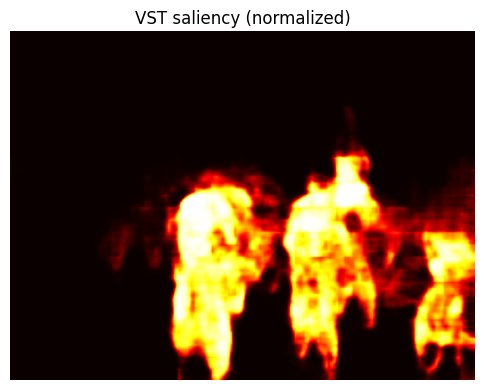

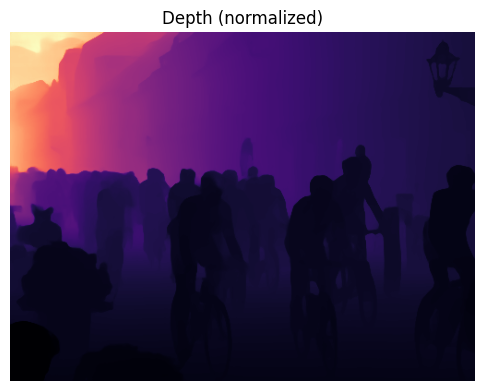

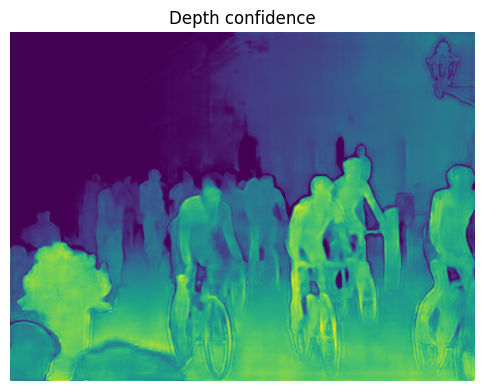

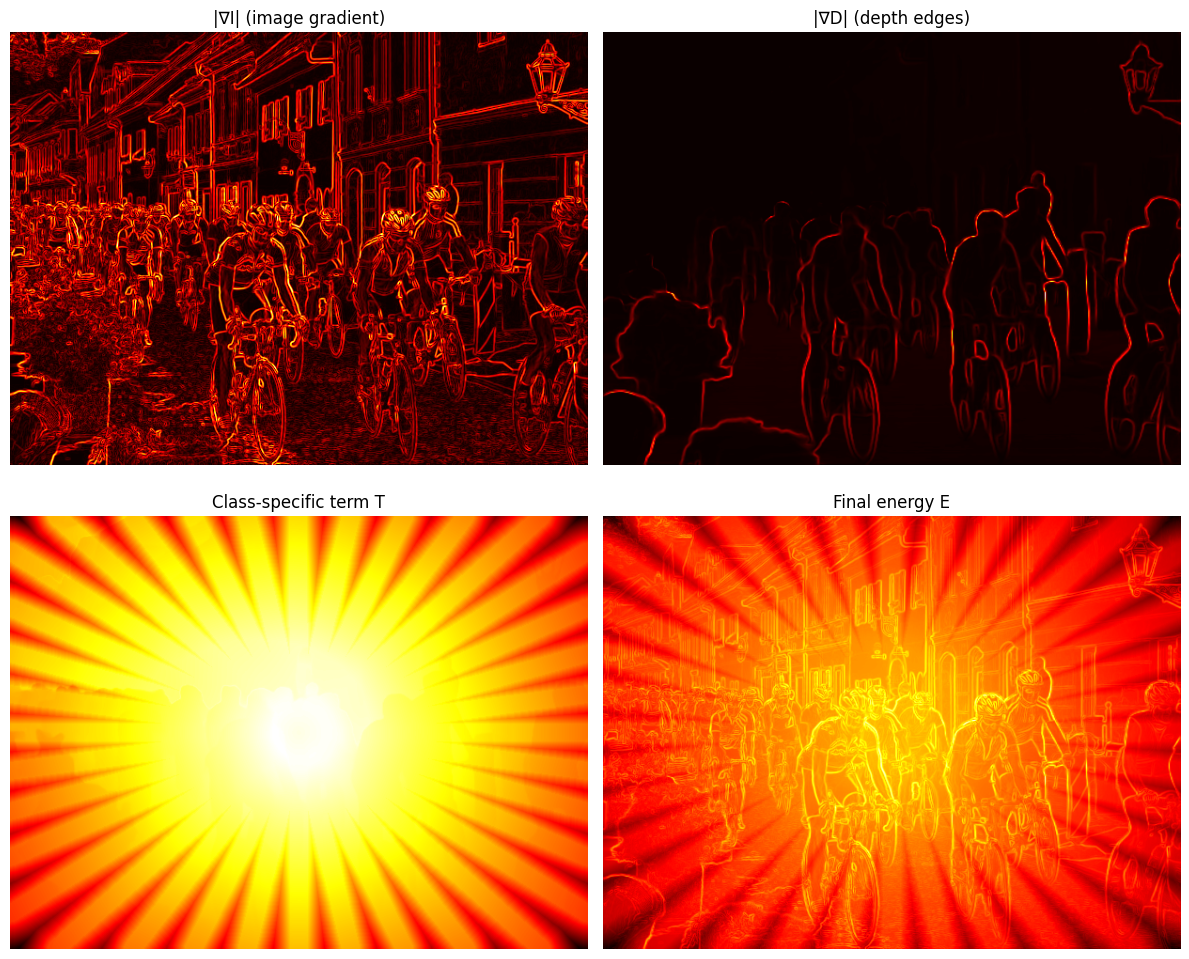

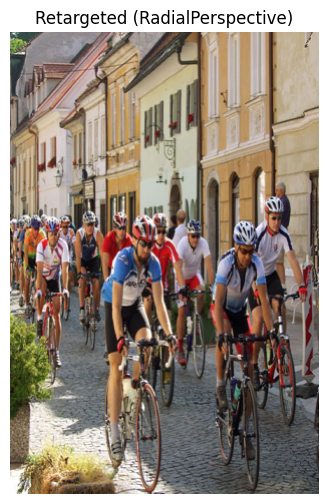

Ops tail: ['seam', 'seam', 'seam', 'seam', 'seam', 'seam', 'seam', 'seam', 'seam', 'seam']


In [14]:
# Cell 9: Debug run on a single RetargetMe image with visual outputs

# 1) Load image
IMG_PATH = "data/retargetme/bicycle2.png"  # <- change to any image you like
rgb = imread(IMG_PATH)
H, W = rgb.shape[:2]
print("Image size:", H, "x", W)
show_image(rgb, "Original image")

# 2) Compute target size (RetargetMe width-only / height-only style)
Wt, Ht = (None, None)
if RETARGET_DIRECTION == "width":
    Wt = max(1, int(round(W * KEEP_RATIO)))
    Ht = H
else:
    Ht = max(1, int(round(H * KEEP_RATIO)))
    Wt = W
print("Target size:", Ht, "x", Wt)

# 3) Run pipeline
result = pipe.run(rgb, (Wt, Ht))

# 4) Visualize intermediate maps

dbg = result["energy_dbg"]
depth = result["depth"]
conf = result["depth_conf"]
vst_sal = result["vst_saliency"]

# a) VST saliency
if vst_sal is not None:
    show_image(vst_sal, "VST saliency (normalized)", cmap="hot")

# b) Depth & confidence
if depth is not None:
    depth_norm = normalize01(depth)
    show_image(depth_norm, "Depth (normalized)", cmap="magma")
if conf is not None:
    conf_norm = normalize01(conf)
    show_image(conf_norm, "Depth confidence", cmap="viridis")

# c) Gradient, depth edges, class term, final energy
show_images_grid(
    [
        dbg["G"],
        dbg["dE"],
        dbg["T"],
        dbg["E"],
    ],
    titles=[
        "|∇I| (image gradient)",
        "|∇D| (depth edges)",
        "Class-specific term T",
        "Final energy E",
    ],
    cmaps=["hot", "hot", "hot", "hot"],
    cols=2,
    figsize=(12, 10),
)

# 5) Final retargeted result
out = result["out"]
show_image(out, f"Retargeted ({result['pred_class_name']})")

print("Ops tail:", result["log"]["ops"][-10:] if result["log"]["ops"] else [])


In [ ]:

---

## 3. Extra notebook cell: loop over all ~80 images

Here’s the **extra Jupyter cell** you asked for.  
Drop it at the end of the notebook (after the single-image debug run):

```python
# Cell X: Batch retargeting on the full RetargetMe dataset

from pathlib import Path
import json
import time

# Config (uses same RETARGET_DIRECTION and KEEP_RATIO as earlier cells)
images_dir = Path("data/retargetme/")
out_dir = Path("results/retargetme")
out_dir.mkdir(parents=True, exist_ok=True)

direction_tag = RETARGET_DIRECTION  # "width" or "height"
keep_tag = int(KEEP_RATIO * 100)

exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
image_paths = sorted([p for p in images_dir.iterdir() if p.suffix.lower() in exts])

print(f"Found {len(image_paths)} images in {images_dir}")

for idx, img_path in enumerate(image_paths, 1):
    print("\n" + "=" * 80)
    print(f"[{idx}/{len(image_paths)}] {img_path.name}")

    try:
        rgb = imread(img_path)
        H, W = rgb.shape[:2]

        # Compute target size based on direction + keep ratio
        if RETARGET_DIRECTION == "width":
            target_w = max(1, int(round(W * KEEP_RATIO)))
            target_h = H
        else:  # "height"
            target_h = max(1, int(round(H * KEEP_RATIO)))
            target_w = W

        t0 = time.time()
        result = pipe.run(rgb, (target_w, target_h))
        elapsed = time.time() - t0

        out_img = result["out"]
        class_name = result["pred_class_name"]
        ops_log = result["log"]["ops"]

        stem = img_path.stem
        out_name = f"{stem}_{direction_tag}{keep_tag}.png"
        out_meta_name = f"{stem}_{direction_tag}{keep_tag}_meta.json"

        out_path = out_dir / out_name
        imwrite(out_path, out_img)

        meta = {
            "input": str(img_path),
            "output": str(out_path),
            "orig_size": [int(H), int(W)],
            "target_size": [int(out_img.shape[0]), int(out_img.shape[1])],
            "direction": direction_tag,
            "keep_ratio": float(KEEP_RATIO),
            "pred_class": int(result["pred_class"]),
            "pred_class_name": class_name,
            "probs": result["probs"],
            "ops_tail": ops_log[-10:] if ops_log else [],
            "runtime_sec": float(elapsed),
        }

        with open(out_dir / out_meta_name, "w") as f:
            json.dump(meta, f, indent=2)

        print(f"✓ Saved {out_name} ({class_name})")
        print(f"  Meta: {out_meta_name}")
    except Exception as e:
        print(f"✗ Error on {img_path.name}: {e}")
